In [1]:
%load_ext autoreload 
%autoreload 2

# Exp4 Pretrain DCGAN to obtain feature extractor

In [2]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

from networks import weights_init, Generator_64, Discriminator_64, Generator_128_v2, Discriminator_128_v2
from loader import All_fundus_files

In [3]:
# settings
dataroot = None
batch_size = 128
image_size = 128 #size using data aug.

ch_out = 3 
ch_noise = 100
ch_g = 64
ch_d = 64

num_epochs = 50
lr = 0.0002
beta1 = 0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
# dataloader
'''
train_dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
'''
train_dataset = All_fundus_files(transform=transforms.Compose([
                           transforms.Resize(image_size),
                           transforms.CenterCrop(image_size),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())
print(len(train_dataset))

# networks
#net_G = Generator_64(ch_noise, ch_g, ch_out).to(device)
net_G = Generator_128_v2(ch_noise, ch_g, ch_out).to(device)
net_G.apply(weights_init)
print(net_G)

#net_D = Discriminator_64(ch_out, ch_d).to(device)
net_D = Discriminator_128_v2(ch_out, ch_d).to(device)
net_D.apply(weights_init)
print(net_D)

# loss and optimizer
criterion = nn.BCELoss()
optimizer_D = optim.Adam(net_D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G = optim.Adam(net_G.parameters(), lr=lr, betas=(beta1, 0.999))
lr_scheduler_G = optim.lr_scheduler.MultiStepLR(optimizer_D, [10,25], gamma=0.1)
lr_scheduler_D = optim.lr_scheduler.MultiStepLR(optimizer_G, [10,25], gamma=0.1)

41317
41317
Generator_128_v2(
  (backbone): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=

In [6]:
def cv2_imwrite(path, image):
    image = np.clip(np.round(image*255),0,255)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, image)

### Adding tricks to improve convergence
# https://github.com/soumith/ganhacks
# adding soft label and label noise
def train_one_epoch(epoch, dataloader, net_G, net_D, optimizer_G, optimizer_D, num_epochs, fixed_noise, ch_noise, device):
    G_losses = []
    D_losses = []
    for iteration, data in enumerate(dataloader, 0):
        ### Update D
        net_G.train()
        net_D.train()
        #data
        real_data = data[0].to(device)
        batch_size = real_data.size(0)
        #real_label = torch.ones((batch_size,), dtype=torch.float, device=device)
        real_label_tmp = torch.rand((batch_size,))*0.5+0.7 #use soft label
        
        noise = torch.randn(batch_size, ch_noise, 1, 1, device=device) #(b,c,1,1)
        fake_data = net_G(noise)
        #fake_label = torch.zeros((batch_size,), dtype=torch.float, device=device)
        fake_label_tmp = torch.rand((batch_size,))*0.3
        
        if torch.rand(1) < 0.05: #add label noise
            real_label = fake_label_tmp.to(device)
            fake_label = real_label_tmp.to(device)
        else:
            real_label = real_label_tmp.to(device)
            fake_label = fake_label_tmp.to(device)
        
        #forward
        real_output = net_D(real_data).view(-1)
        fake_output = net_D(fake_data.detach()).view(-1)
        real_loss_D = criterion(real_output, real_label)
        fake_loss_D = criterion(fake_output, fake_label)
        loss_D = real_loss_D + fake_loss_D
        
        #backward
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()
        

        ### Update G
        #real_label = torch.ones((batch_size,), dtype=torch.float, device=device)
        real_label = torch.rand((batch_size,))*0.5+0.7
        real_label = real_label.to(device)
        fake_output_G = net_D(fake_data).view(-1)
        loss_G = criterion(fake_output_G, real_label)
        
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()
        
        # logs
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())
        if iteration % 50 == 0:
            print('[{:d}/{:d}] Iter:{:d}  Loss_D={:.4f} Loss_G={:.4f} D(x)={:.4f} D(G(z))={:.4f}, {:.4f}'.format(
                  epoch, num_epochs, iteration+1, loss_D.item(), loss_G.item(), real_output.mean().item(), fake_output.mean().item(), fake_output_G.mean().item()))
        
        # test
        if (iteration == len(dataloader)//2) or (iteration == len(dataloader)-1):
            net_G.eval()
            net_D.eval()
            with torch.no_grad():
                fake_images = net_G(fixed_noise).detach().cpu()
            fake_images = np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True),(1,2,0))
            #print(fake_images)
            cv2_imwrite('./fig_exp4/epoch{}Iter{}.png'.format(epoch, iteration), fake_images.numpy())
    return G_losses, D_losses


In [7]:
# Training
G_losses = []
D_losses = []
fixed_noise = torch.randn(64, ch_noise, 1, 1, device=device)
# For each epoch
for epoch in range(num_epochs):
    g,d = train_one_epoch(epoch, train_dataloader, net_G, net_D, optimizer_G, optimizer_D, num_epochs, fixed_noise, ch_noise, device)
    G_losses += g
    D_losses += d
    lr_scheduler_G.step()
    lr_scheduler_D.step()

[0/50] Iter:1  Loss_D=2.9047 Loss_G=0.6243 D(x)=0.1998 D(G(z))=0.3002, 0.5909
[0/50] Iter:51  Loss_D=7.0815 Loss_G=32.2790 D(x)=0.9748 D(G(z))=0.0000, 0.0000
[0/50] Iter:101  Loss_D=84.9436 Loss_G=2.7903 D(x)=0.9904 D(G(z))=1.0000, 1.0000
[0/50] Iter:151  Loss_D=85.2771 Loss_G=4.6582 D(x)=0.8878 D(G(z))=1.0000, 1.0000
[0/50] Iter:201  Loss_D=85.3750 Loss_G=4.3438 D(x)=0.9049 D(G(z))=1.0000, 1.0000
[0/50] Iter:251  Loss_D=85.8219 Loss_G=6.0111 D(x)=0.9663 D(G(z))=1.0000, 1.0000
[0/50] Iter:301  Loss_D=86.3074 Loss_G=5.6654 D(x)=0.3942 D(G(z))=1.0000, 1.0000
[1/50] Iter:1  Loss_D=85.7110 Loss_G=1.4763 D(x)=0.9378 D(G(z))=1.0000, 1.0000
[1/50] Iter:51  Loss_D=84.8214 Loss_G=5.9562 D(x)=0.9422 D(G(z))=1.0000, 1.0000
[1/50] Iter:101  Loss_D=84.4078 Loss_G=4.9771 D(x)=0.9347 D(G(z))=1.0000, 1.0000
[1/50] Iter:151  Loss_D=85.0765 Loss_G=1.0788 D(x)=0.9179 D(G(z))=1.0000, 1.0000
[1/50] Iter:201  Loss_D=85.3523 Loss_G=5.8366 D(x)=0.7717 D(G(z))=1.0000, 1.0000
[1/50] Iter:251  Loss_D=85.2422 Los

[14/50] Iter:251  Loss_D=0.8888 Loss_G=1.3009 D(x)=0.7306 D(G(z))=0.2411, 0.2927
[14/50] Iter:301  Loss_D=0.8579 Loss_G=1.2592 D(x)=0.7800 D(G(z))=0.2914, 0.3021
[15/50] Iter:1  Loss_D=0.8488 Loss_G=1.3427 D(x)=0.7608 D(G(z))=0.2702, 0.2832
[15/50] Iter:51  Loss_D=0.8676 Loss_G=1.2414 D(x)=0.8131 D(G(z))=0.3843, 0.3038
[15/50] Iter:101  Loss_D=0.8710 Loss_G=1.0613 D(x)=0.7402 D(G(z))=0.2466, 0.3849
[15/50] Iter:151  Loss_D=1.0579 Loss_G=0.9497 D(x)=0.7234 D(G(z))=0.3850, 0.4162
[15/50] Iter:201  Loss_D=2.4531 Loss_G=0.8777 D(x)=0.7359 D(G(z))=0.3624, 0.4516
[15/50] Iter:251  Loss_D=0.9451 Loss_G=1.1529 D(x)=0.8036 D(G(z))=0.4417, 0.3240
[15/50] Iter:301  Loss_D=1.0190 Loss_G=1.0732 D(x)=0.8093 D(G(z))=0.4675, 0.3551
[16/50] Iter:1  Loss_D=0.8869 Loss_G=1.2436 D(x)=0.7930 D(G(z))=0.3637, 0.3036
[16/50] Iter:51  Loss_D=0.8527 Loss_G=1.2858 D(x)=0.7209 D(G(z))=0.2349, 0.2930
[16/50] Iter:101  Loss_D=2.9378 Loss_G=1.0937 D(x)=0.7754 D(G(z))=0.2473, 0.3514
[16/50] Iter:151  Loss_D=0.8904 Lo

[29/50] Iter:101  Loss_D=0.8472 Loss_G=1.4832 D(x)=0.7395 D(G(z))=0.2163, 0.2311
[29/50] Iter:151  Loss_D=0.8575 Loss_G=1.0020 D(x)=0.8080 D(G(z))=0.3748, 0.3756
[29/50] Iter:201  Loss_D=0.8299 Loss_G=1.1145 D(x)=0.8139 D(G(z))=0.3474, 0.3403
[29/50] Iter:251  Loss_D=0.9777 Loss_G=1.0778 D(x)=0.6994 D(G(z))=0.3543, 0.3571
[29/50] Iter:301  Loss_D=0.8805 Loss_G=1.1708 D(x)=0.8360 D(G(z))=0.3403, 0.3180
[30/50] Iter:1  Loss_D=1.1110 Loss_G=1.1472 D(x)=0.6060 D(G(z))=0.3015, 0.3310
[30/50] Iter:51  Loss_D=0.9062 Loss_G=1.0281 D(x)=0.7667 D(G(z))=0.3735, 0.3702
[30/50] Iter:101  Loss_D=0.7477 Loss_G=1.2126 D(x)=0.8586 D(G(z))=0.3205, 0.3114
[30/50] Iter:151  Loss_D=0.8026 Loss_G=1.2705 D(x)=0.8396 D(G(z))=0.3038, 0.2981
[30/50] Iter:201  Loss_D=0.9704 Loss_G=0.9680 D(x)=0.7824 D(G(z))=0.4308, 0.3881
[30/50] Iter:251  Loss_D=0.9032 Loss_G=1.3605 D(x)=0.6955 D(G(z))=0.2437, 0.2606
[30/50] Iter:301  Loss_D=0.8800 Loss_G=1.1716 D(x)=0.7745 D(G(z))=0.3277, 0.3279
[31/50] Iter:1  Loss_D=0.7944 L

[43/50] Iter:301  Loss_D=0.8277 Loss_G=1.0921 D(x)=0.8278 D(G(z))=0.3398, 0.3452
[44/50] Iter:1  Loss_D=0.7917 Loss_G=1.3630 D(x)=0.7997 D(G(z))=0.2654, 0.2623
[44/50] Iter:51  Loss_D=0.9234 Loss_G=1.3397 D(x)=0.6886 D(G(z))=0.2694, 0.2798
[44/50] Iter:101  Loss_D=0.7560 Loss_G=1.2469 D(x)=0.8306 D(G(z))=0.2918, 0.2936
[44/50] Iter:151  Loss_D=0.8324 Loss_G=1.3088 D(x)=0.7662 D(G(z))=0.2666, 0.2842
[44/50] Iter:201  Loss_D=0.9505 Loss_G=1.0751 D(x)=0.7364 D(G(z))=0.3452, 0.3462
[44/50] Iter:251  Loss_D=0.8580 Loss_G=1.3631 D(x)=0.7584 D(G(z))=0.2618, 0.2590
[44/50] Iter:301  Loss_D=0.8737 Loss_G=1.1069 D(x)=0.8002 D(G(z))=0.3733, 0.3462
[45/50] Iter:1  Loss_D=0.8706 Loss_G=1.0811 D(x)=0.7994 D(G(z))=0.3361, 0.3457
[45/50] Iter:51  Loss_D=0.8446 Loss_G=1.2062 D(x)=0.8047 D(G(z))=0.3343, 0.3095
[45/50] Iter:101  Loss_D=0.9432 Loss_G=0.9204 D(x)=0.8339 D(G(z))=0.4463, 0.4053
[45/50] Iter:151  Loss_D=0.7407 Loss_G=1.2325 D(x)=0.8592 D(G(z))=0.3266, 0.3030
[45/50] Iter:201  Loss_D=0.7194 Lo

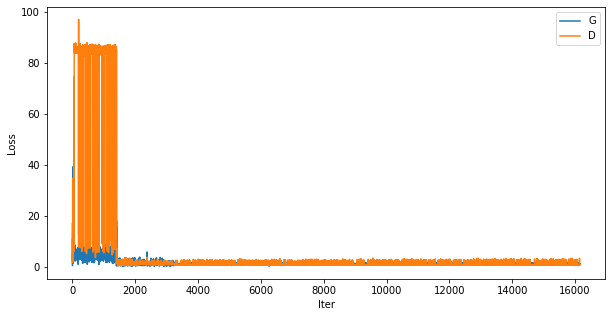

In [11]:
# check loss
plt.figure(figsize=(10,5))
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iter")
plt.ylabel("Loss")
plt.legend()
plt.show()

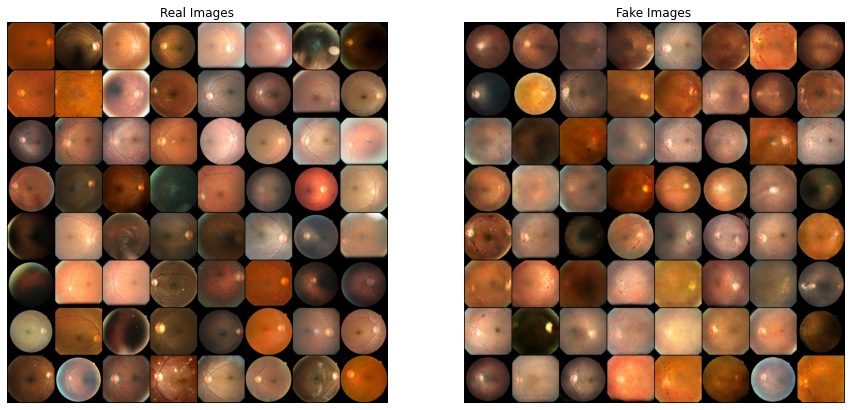

In [9]:
# check images
real_images = next(iter(train_dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(np.transpose(vutils.make_grid(real_images[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.axis("off")
plt.title("Real Images")

plt.subplot(1,2,2)
fake_images = net_G(fixed_noise).detach().cpu()
fake_images = np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True),(1,2,0))
plt.imshow(fake_images)
plt.axis("off")
plt.title("Fake Images")
plt.show()

In [12]:
#Save
state = {
    'net': net_D.state_dict(),
    'acc': 0,
    'epoch': num_epochs,
}
if not os.path.isdir('checkpoint/exp4'):
    os.mkdir('checkpoint/exp4')
torch.save(state, './checkpoint/exp4/ckpt.pth')